# Predicting AirBnB prices in Lisbon: Trees and Random Forests

In this small article we will quickly bootstrap a prediction model for the nighly prices of an AirBnB in Lisbon. This guide hopes to serve as a simplistic and practical introduction to machine learning data analysis, by using real data and developing a real model.

It assumes as well basic understanding of Python and the machine learning library [scikit-learn](https://scikit-learn.org/stable/), and it was written on a Jupyter notebook running Python 3.6 and sklearn 0.21. The dataset, as well as the notebook, can be obtained on my Github account, or via [Google's dataset search](https://datasetsearch.research.google.com/search?query=lisbon%20airbnb&docid=c6zMqHvIlOwEwlHEAAAAAA%3D%3D).

## 1. Data exploration and cleanup

As the first step we start by loading our dataset. After downloading the file it is trivial to open and parse it with Pandas and provide a quick list of what we could expect from it:

In [23]:
import pandas as pd

airbnb_lisbon_prices_path = './airbnb_lisbon_1480_2017-07-27.csv'
airbnb_data = pd.read_csv(airbnb_lisbon_prices_path)

airbnb_data.columns

Index(['room_id', 'survey_id', 'host_id', 'room_type', 'country', 'city',
       'borough', 'neighborhood', 'reviews', 'overall_satisfaction',
       'accommodates', 'bedrooms', 'bathrooms', 'price', 'minstay', 'name',
       'last_modified', 'latitude', 'longitude', 'location'],
      dtype='object')

Even though above we can confirm that the dataset was properly loaded and parsed, a quick analysis of the statistical description of the data may provide us a quick insight of its nature:

In [24]:
airbnb_data.describe()

room_id  survey_id       host_id  country  borough       reviews  \
count  1.357800e+04    13578.0  1.357800e+04      0.0      0.0  13578.000000   
mean   1.128653e+07     1480.0  4.031780e+07      NaN      NaN     29.507512   
std    6.331112e+06        0.0  4.120258e+07      NaN      NaN     43.657402   
min    6.499000e+03     1480.0  1.445500e+04      NaN      NaN      0.000000   
25%    5.611757e+06     1480.0  6.855202e+06      NaN      NaN      1.000000   
50%    1.253847e+07     1480.0  2.393412e+07      NaN      NaN     11.000000   
75%    1.718596e+07     1480.0  6.298880e+07      NaN      NaN     40.000000   
max    2.009103e+07     1480.0  1.426582e+08      NaN      NaN    448.000000   

       overall_satisfaction  accommodates      bedrooms  bathrooms  \
count          13578.000000  13578.000000  13578.000000        0.0   
mean               3.242046      3.872956      1.535793        NaN   
std                2.151046      2.254779      1.042837        NaN   
min                0.000000      1.000000      0.000000        NaN   
25%                0.000000      2.000000      1.000000        NaN   
50%                4.500000      4.000000      1.000000        NaN   
75%                5.000000      5.000000      2.000000        NaN   
max                5.000000     16.000000     10.000000        NaN   

              price  minstay      latitude     longitude  
count  13578.000000      0.0  13578.000000  13578.000000  
mean      88.376712      NaN     38.720882     -9.143594  
std      123.044522      NaN      0.015134      0.017923  
min       10.000000      NaN     38.692112     -9.226461  
25%       48.000000      NaN     38.711405     -9.150805  
50%       70.000000      NaN     38.715857     -9.141973  
75%       96.000000      NaN     38.726283     -9.132693  
max     4203.000000      NaN     38.792573     -9.091610

From this table we can actually infer about basic statistical observations for each of our parameters. As our model intends to predict the price, based on whatever set of inputs we'll provide to it, we could check for example that:

- the mean value of the nighly price is around **88 EUR**
- the prices range from a minimum of **10 EUR** to **4203 EUR**
- the standard deviation for the prices is around **123 EUR** (!)

The price distribution could be represented as follows:

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


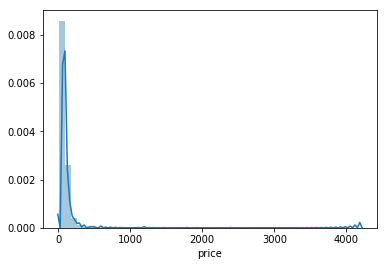

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.plotting.register_matplotlib_converters()

sns.distplot(a=airbnb_data['price'])

As we can see, our distribution of prices concentrates, under the **300 EUR** interval, having some entries for the **4000 EUR** values. Plotting it for where most of the prices reside:

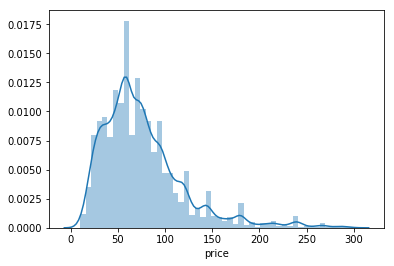

In [26]:
airbnb_sub_set = airbnb_data.loc[airbnb_data.price < 300]
sns.distplot(a=airbnb_sub_set['price'])

We can clearly see from our representation above that most of the prices, for a night in Lisbon, will cost between **0-150 EUR**. 

Let us now pry and have a sneak peak into the actual dataset, in order to understand the kind of parameters we'll be working on:

In [27]:
airbnb_data.head()

room_id  survey_id   host_id    room_type  country    city  borough  \
0  14708916       1480  91501272  Shared room      NaN  Lisbon      NaN   
1   7465447       1480    704061  Shared room      NaN  Lisbon      NaN   
2  11058290       1480   1379661  Shared room      NaN  Lisbon      NaN   
3   9019111       1480  46762399  Shared room      NaN  Lisbon      NaN   
4   3123304       1480   8488955  Shared room      NaN  Lisbon      NaN   

        neighborhood  reviews  overall_satisfaction  accommodates  bedrooms  \
0      Santo António       19                   4.5             4       1.0   
1     Avenidas Novas        4                   3.5             6       1.0   
2  Santa Maria Maior       38                   4.5             8       1.0   
3     Avenidas Novas        9                   4.0             6       1.0   
4            Arroios        0                   0.0             2       1.0   

   bathrooms  price  minstay                                         name  \
0        NaN   30.0      NaN   LOW COST HOSTEL MARQUES GARDENS 4 BED DORM   
1        NaN   39.0      NaN                        Room in Lisbon center   
2        NaN   39.0      NaN  Bed in a 8-bed dorm @ This Is Lisbon Hostel   
3        NaN   37.0      NaN                  Shared mixed bunkbed room 1   
4        NaN  480.0      NaN                   quarto no centro de lisboa   

                last_modified   latitude  longitude  \
0  2017-07-28 01:19:53.215272  38.723987  -9.146613   
1  2017-07-28 01:19:53.206052  38.735061  -9.154510   
2  2017-07-28 01:19:52.034547  38.715726  -9.132671   
3  2017-07-28 01:19:52.020396  38.729017  -9.149932   
4  2017-07-28 01:19:50.401364  38.721617  -9.136208   

                                            location  
0  0101000020E61000003F56F0DB104B22C055DD239BAB5C...  
1  0101000020E610000057CF49EF1B4F22C054C8957A165E...  
2  0101000020E610000057410C74ED4322C0CD72D9E89C5B...  
3  0101000020E61000006C3F19E3C34C22C0309DD66D505D...  
4  0101000020E61000003AE8120EBD4522C06B9E23F25D5C...

From the description above we should be able to infer some statistical data about the nature of the data. Besides the distribution set of parameters (that we will not be looking for now), we clearly identify two sets of relevant insights:

- there are empty columns: `country`, `borough`, `bathrooms`, `minstay`
- entries like `host_id`, `survey_id`, `room_id`, `name`, `city`, `last_modified` and `survey_id` may not be so relevant for our price predictor
- there are some categorical data that we will not be able to initially add to the regression of the Price, such as `room_type` and `neighborhood` (but we'll be back to these two later on)
- `location` may be redundant for now, when we have both `latitude` and `longitude` and we may need to further infer about the nature of the format of this field

Let us then proceed on separating the dataset in:

- one vector **Y** that will contain all the real prices of the dataset
- on matrix **X** that contains all the features that we consider relevant for our model

This can be achieved by the following snippet:

In [28]:
lisbon_features = ['reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'latitude', 'longitude']

Y = airbnb_data.price
X = airbnb_data[lisbon_features]

X.head()

reviews  overall_satisfaction  accommodates  bedrooms   latitude  longitude
0       19                   4.5             4       1.0  38.723987  -9.146613
1        4                   3.5             6       1.0  38.735061  -9.154510
2       38                   4.5             8       1.0  38.715726  -9.132671
3        9                   4.0             6       1.0  38.729017  -9.149932
4        0                   0.0             2       1.0  38.721617  -9.136208

With our new subset, we can now try to understand what is the correlation of these parameters in terms of the overall satisfaction, for the most common price range:

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


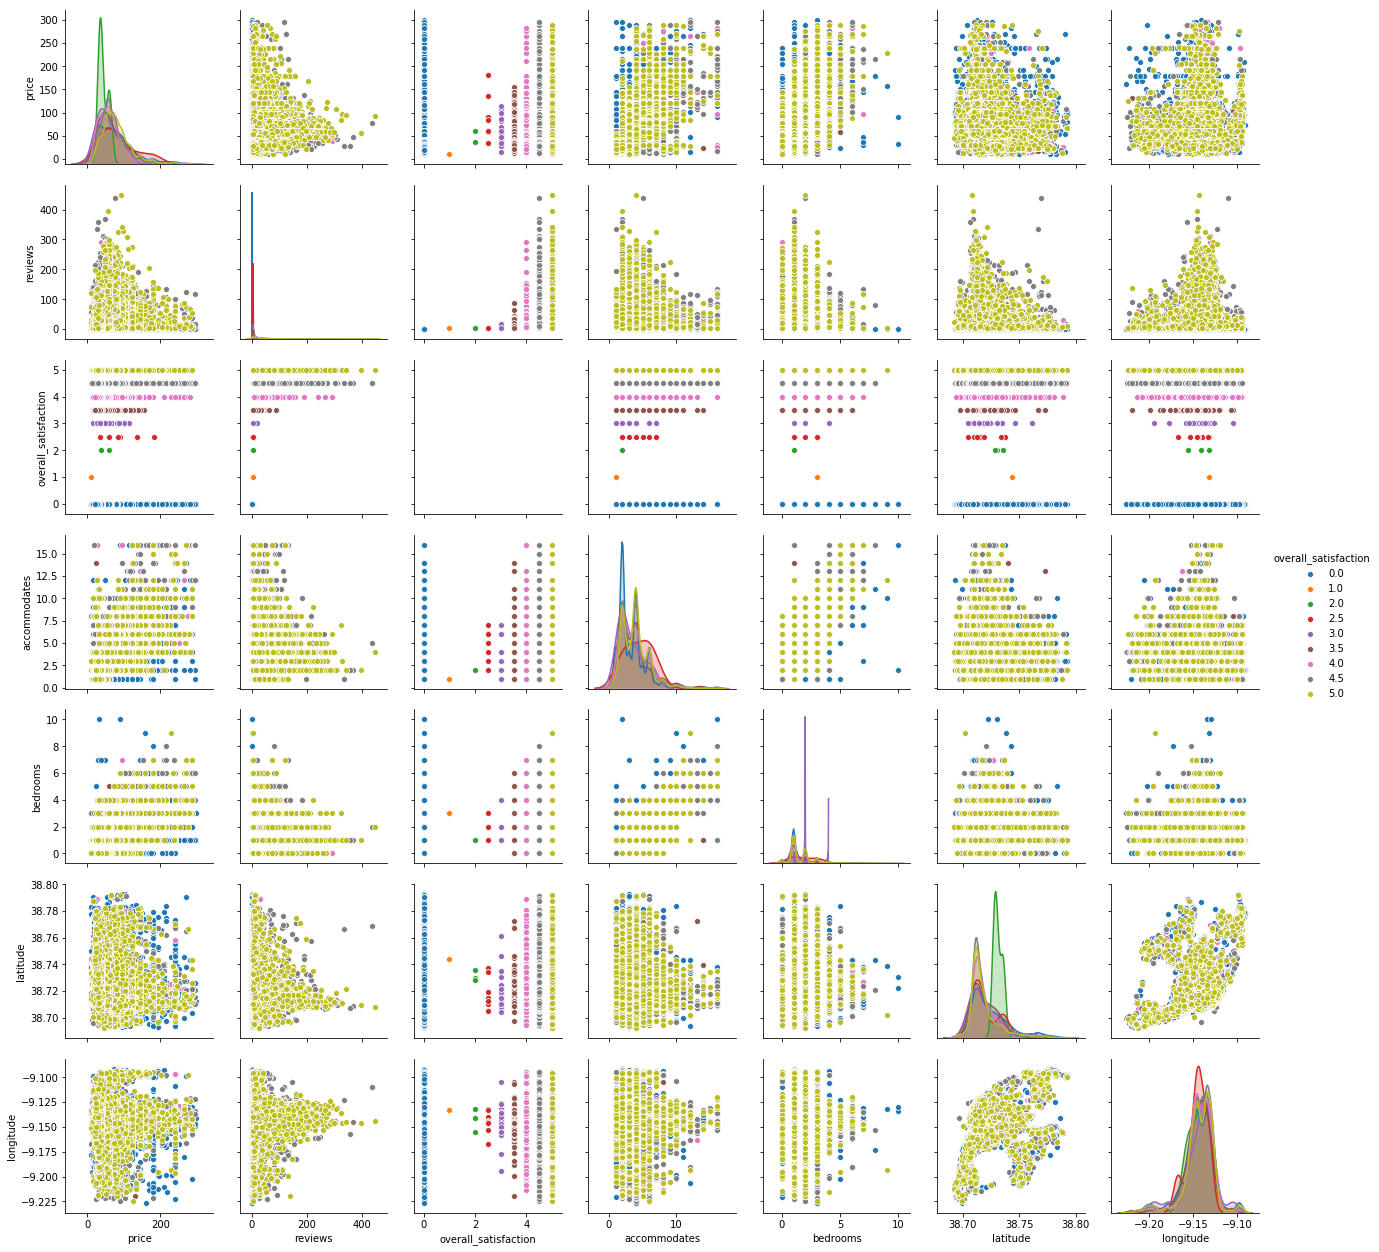

In [29]:
relevant_parameters = ['price'] + lisbon_features
sns.pairplot(airbnb_data.loc[airbnb_data.price < 300][relevant_parameters], hue="overall_satisfaction")

The above plots allow us to check the distribution of all the single variables and try to infer about the reationships between them. We've took the freedom to apply a color hue based on the review values for each of our chosen parameters. Some easy reading examples of the above figure, from relations that may detones a positive correlation:

- the number of reviews is more common for rooms with few accomodations. This could mean that most of the guests that review are renting smaller rooms.
- most of the reviews are made for the cheaper priced rooms
- taking into account the visual dominance of the yellow hue, most of the reviews are actually rated with 5. Either this means that most of the accomodations are actually very satisfatory or, most probably, the large amount of people that actually review, does it to give 5 as rating.

On curious observation is also that the location heavily influences price and rating. When plotting both longitude and latitudw we can obtain a quasi geografical / spacial distribution for the ratings along Lisbon:

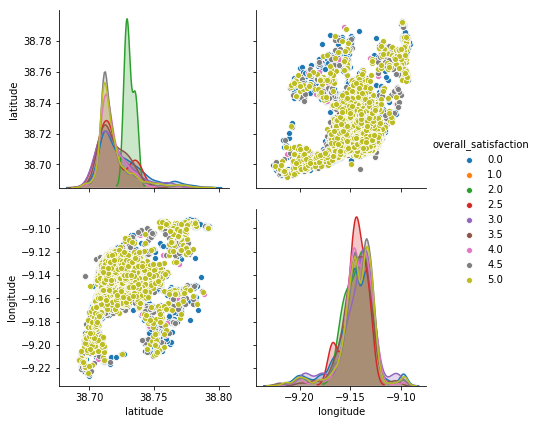

In [30]:
sns.pairplot(airbnb_data, vars=['latitude', 'longitude'], hue="overall_satisfaction", height=3)

We can then add this data to an actual map of Lisbon, to check the distribution:

![distribution of reviews](./lisbon_mapped_reviews.png)

As expected, most of the reviews are on the city center with a cluster of reviews already relevant alongside the recent Parque das Nações. The northern more sub-urban area, even though it has some scattered places, the reviews are not as high and common as on the center. 

## 2. Splitting the dataset

With our dataset now properly cleared we will then first proceed into splitting it into two pieces:

- a set that will be responsible for training our model, therefore called the **training set**
- a **validation set** that will be used to then validate our model

Both sets would then basically be a subset of **X** and **Y**, containing a subset of the rental spaces and their corresponding prices. We would then, after training our model, to use the validation set as a input to then infer how good is our model on generalizing into data sets other than the ones used to train. When a model is performing very well on the training set, but does not generalize well to other data, we say that the model is **overfitted** to the dataset. For further information on overfitting, please refer to: https://en.wikipedia.org/wiki/Overfitting

In order to avoid this **overfitting** of our model to the test data we will then use a tool from sklearn called https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html that basically will split our data into a random train of train and test subsets:

In [31]:
from sklearn.model_selection import train_test_split

train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, random_state = 42)

print("Training set: Xt:{} Yt:{}".format(train_X.shape, train_Y.shape))
print("Validation set: Xv:{} Yv:{}".format(validation_X.shape, validation_Y.shape))
print("-")
print("Full dataset: X:{} Y:{}".format(X.shape, Y.shape))

Training set: Xt:(10183, 6) Yt:(10183,)
Validation set: Xv:(3395, 6) Yv:(3395,)
-
Full dataset: X:(13578, 6) Y:(13578,)


Now that we have our datasets in place, we can now proceed on creating a simple regression model that will try to predict, based on our choosen parameters, the nighly cost of an AirBnb in Lisbon.

## 3. Planting the Decision Trees

As one of the most simplistic supervised ML models, a decision tree is usually used to predict an outcome by learning and infering decision rules from all the features data available. By ingesting our data parameters the trees can learn a series of educated "questions" in order to partition our data in a way that we can use the resulting data structure to either classify categorial data, or simply create a regression model for numerical values (as it is our case with the prices).

An visualization example, taken from [wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning), could be the decision tree around the prediction for survival of passangers in the Titanic:

![A tree showing survival of passengers on the Titanic ("sibsp" is the number of spouses or siblings aboard), from wikipedia](./CART_tree_titanic_survivors.png)

Based on the data, the tree is built on the root and will be (recursively) partitioned by splitting each node into two child ones. These resulting nodes will be split, based on decisions that are infered about the statistical data we are providing to the model, until we reach a point where the data split results in the biggest information gain, meaning we can properly classify all the samples based on the classes we are iteratively creating. To these end vertices we call "leaves". 

On the wikipedia example above it is trivial to follow how the decision process follows and, as the probability of survival is the estimated parameter here, we can easily obtain the probability of a "male, with more than 9.5 years old" survives when "he has no siblings".

(For a more deep understanding on how decision trees are built for regression I would recomend the video by [StatQuest, named Decision Trees](https://statquest.org/2018/01/22/statquest-decision-trees/)).

Let us then create our Decision Tree regressor by utilizing the [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decisiontreeregressor#sklearn.tree.DecisionTreeRegressor):

In [33]:
from sklearn.tree import DecisionTreeRegressor

lisbon_airbnb_model = DecisionTreeRegressor(random_state = 42)
lisbon_airbnb_model.fit(train_X, train_Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

We can verify how the tree was built, for illustration purposes, on the picture below:

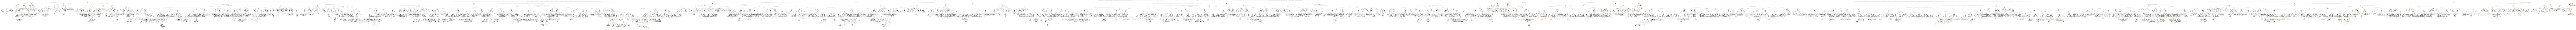

In [38]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(lisbon_airbnb_model, out_file='tree.dot', filled=True, rounded=True, special_characters=True)  

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

We can also show a snippet of the predictions, and corresponding parameters for a sample of the training data set. So for the following accomodations:

In [41]:
train_X.head()

reviews  overall_satisfaction  accommodates  bedrooms   latitude  \
11956       29                   4.5             2       1.0  38.717426   
5665        75                   5.0             5       2.0  38.716165   
11639        2                   0.0             3       1.0  38.709567   
13391        4                   5.0             2       1.0  38.727817   
3219         1                   0.0             6       3.0  38.723333   

       longitude  
11956  -9.156587  
5665   -9.144141  
11639  -9.143207  
13391  -9.133753  
3219   -9.130640

We obtain the following prices:

In [42]:
lisbon_airbnb_model.predict(train_X.head())

array([ 30.,  81.,  60.,  30., 121.])

After fitting our model to the train data, we can now run a prediction for the validation set and assess the current absolute error of our model to assess on how good it generalizes when not run agains the data it was tested.

For this we'll use the **Mean Absolute Error** (MAE) metric. We can consider this metric as the average error magnitude in a predictions set. It can be represented as such:

$$MAE = {1 \over n}{\sum_{i=1}^{n}{\left|y_i - \hat{y}_i\right|}}$$

It is basically an average over the the differences between our model predictions (y) and actual observations (_y-hat_), and making the consideration that all individual differences have equal weight.

Let us then apply this metric to our model, using [Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) implementation:

In [43]:
from sklearn.metrics import mean_absolute_error

# instruct our model to make predictions for the prices on the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X)

# calculate the MAE between the actual prices (in validation_Y) and the predictions made
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

42.91664212076583

This result basically means that our model is giving an absolute error of about **42.935 EUR** per accomodation when exposed to the test data, out of a **88.38 EUR** mean value that we collected during the initial data exploration.

Either due to our dataset being small, and to our model being naife, this result is not satisfactory. 

Even though this may seem worriyng at this point, it is always advised to create a model that generates results as soon as possible and then start iterating on its optimization. Therefore, let us now proceed on attempting to imporve our model's predictions a bit more.

Currently we are indeed suffering for overfitting on the test data. If we imagine the decision tree that is being built, as we are not specifying a limit for the decisions to split, we will consequently generate a decision tree that goes way deep until the test features, not generalizing well on any test set.

As sklearn's `DecisionTreeRegressor` allows us to specify a maximum number of leaf nodes as an hyper parameter, let us quickly try to assess if there is a value that decreses our MAE:

In [44]:
# this function takes both the training and validation sets to compute the MAE for a Decision Tree
def compute_mae(train_X, train_Y, validation_X, validation_Y, max_leaf_nodes):
    trees_model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 42)
    trees_model.fit(train_X, train_Y)
    validation_predictions = trees_model.predict(validation_X)
    error = mean_absolute_error(validation_Y, validation_predictions)
    
    return(error)

def get_best_tree_size(train_X, train_Y, validation_X, validation_Y, verbose = False):
    # candidates to iterate on finding a better tree depth
    candidate_max_leaf_nodes = [5, 10, 20, 30, 50, 100, 250, 500]

    # initialization
    minimum_error = None
    best_tree_size = 5

    # loop to find the minimal error value
    for max_leaf_nodes in candidate_max_leaf_nodes:
        current_error = compute_mae(train_X, train_Y, validation_X, validation_Y, max_leaf_nodes)
        verbose and print("(Size: {}, MAE: {})".format(max_leaf_nodes, current_error))

        if(minimum_error == None or current_error < minimum_error):
            minimum_error = current_error
            best_tree_size = max_leaf_nodes

    return(best_tree_size)

best_tree_size = get_best_tree_size(train_X, train_Y, validation_X, validation_Y, True)

best_tree_size

(Size: 5, MAE: 42.6016036138866)
(Size: 10, MAE: 40.951013502542885)
(Size: 20, MAE: 40.00407688450048)
(Size: 30, MAE: 39.6249335490541)
(Size: 50, MAE: 39.038730827750555)
(Size: 100, MAE: 37.72578309289501)
(Size: 250, MAE: 36.82474862034445)
(Size: 500, MAE: 37.58889602439078)


250

Let us then try to generate our model, but including the computed max tree size, and check then its prediction with the new limit:

In [45]:
# create the model
lisbon_airbnb_model = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state = 42)
lisbon_airbnb_model.fit(train_X, train_Y)

# generate the predictions for the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X)
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

36.82474862034445

So by simply tunning up our maximum number of leaf nodes hyperparameter we could then obtain a significant increase of our model's predictions. We have now improved on average (`42.935 - 36.825`) **~ 6.11 EUR** on our model's errors.

## 4. Categorical Data

As mentioned above, even though we are being able to proceed on optimizing our very simplistic model, we still dropped two possible relevant fields that may (or may not) contribute to a better generalization and parameterization of our model: `room_type` and `neighborhood`.

These non-numerical data fields are usually referred to as **Categorical Data**, and most frequently we can approach them in three ways:

**1) Drop** 

Sometimes the easiest way to deal with categorical data is... to remove it from the dataset. We did this to set up our project quickly, but one must go case by case in order to infer about the nature of such fields and if they make sense to be dropped.

This was the scenario we analysed until now, with a MAE of: **36.82474862034445**

**2) Label Encoding** 

So for label encoding we assume that each value is assigned to a unique integer. We an also make this transformation taking into account any kind of ordering/magnitude that may be relevant for data (e.g., ratings, views, ...). Let us check a simple example using the sklearn preprocessor:

In [46]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# initialize with a list of values
encoder.fit(["shared room", "single room", "double room", "suite"])

sample_inputs = ["suite", "suite", "shared room", "double room", "single room"]

encoder.transform(sample_inputs)

array([3, 3, 1, 0, 2])

It is trivial to assess then the transformation that the `LabelEncoder` is doing, by assigning the array index of the fitted data:

In [47]:
encoder.classes_

array(['double room', 'shared room', 'single room', 'suite'], dtype='<U11')

Let us then apply to our categorical data this preprocessing technique, and let us verify how this affects our model predictions. So our new data set would be:

In [48]:
lisbon_features_extended = ['room_type', 'neighborhood', 'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'latitude', 'longitude']
X = airbnb_data[lisbon_features_extended]

X.head()

room_type       neighborhood  reviews  overall_satisfaction  \
0  Shared room      Santo António       19                   4.5   
1  Shared room     Avenidas Novas        4                   3.5   
2  Shared room  Santa Maria Maior       38                   4.5   
3  Shared room     Avenidas Novas        9                   4.0   
4  Shared room            Arroios        0                   0.0   

   accommodates  bedrooms   latitude  longitude  
0             4       1.0  38.723987  -9.146613  
1             6       1.0  38.735061  -9.154510  
2             8       1.0  38.715726  -9.132671  
3             6       1.0  38.729017  -9.149932  
4             2       1.0  38.721617  -9.136208

Our categorical data, represented on our panda's dataframe as an `object`, can then be extracted by:

In [49]:
categorical = (X.dtypes == 'object')
categorial_columns = list(categorical[categorical].index)

categorial_columns

['room_type', 'neighborhood']

Now that we have the columns, let us then transform them on both the training and validation sets:

In [50]:
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, random_state = 42)

# create copies of our data sets to apply the transformations
train_X_encoded = train_X.copy()
validation_X_encoded = validation_X.copy()

encoder = LabelEncoder()

# for each column we fit the encoder and transform each of the rows
for column in categorial_columns:
    train_X_encoded[column] = encoder.fit_transform(train_X[column])
    validation_X_encoded[column] = encoder.transform(validation_X[column])

# a sample of our transformed data
train_X_encoded.head()

room_type  neighborhood  reviews  overall_satisfaction  accommodates  \
11956          1             9       29                   4.5             2   
5665           0            21       75                   5.0             5   
11639          1            15        2                   0.0             3   
13391          1             4        4                   5.0             2   
3219           0            18        1                   0.0             6   

       bedrooms   latitude  longitude  
11956       1.0  38.717426  -9.156587  
5665        2.0  38.716165  -9.144141  
11639       1.0  38.709567  -9.143207  
13391       1.0  38.727817  -9.133753  
3219        3.0  38.723333  -9.130640

Let us now train and fit the model with the transformed data:

In [51]:
# compute the best tree size
best_tree_size = get_best_tree_size(train_X_encoded, train_Y, validation_X_encoded, validation_Y)

# create the model
lisbon_airbnb_model = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state = 42)
lisbon_airbnb_model.fit(train_X_encoded, train_Y)

# generate the predictions for the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X_encoded)
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

35.690195084932355

We have then improved our predictor, by encoding our categorical data, reducing our MAE to **~ 35.69 EUR**.

**3) One-Hot Encoding**

One-Hot encoding, instead of enumerating a fields' possible values, creates new columns indicating the presence or absence of the encoded values. Let us showcase this with a small example

In [52]:
from sklearn.preprocessing import OneHotEncoder

# categories
room_type = ["shared room", "single room", "double room", "suite"]
building_type = ["hotel", "apartement", "iglo"]

# initializing the encoder (non-sparse returns an array, and ignore unknown categories)
encoder = OneHotEncoder(categories=[room_type, building_type], sparse=False, handle_unknown='ignore')

# fitting and transforming the example
encoder.fit_transform([['suite', 'iglo'], ['single room', 'apartement']])

array([[0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0.]])

From the result above we can see that the binary encoding is providing `1` on the features that each feature array actually has enabled, and `0` when not present. Let us then try to use this preprocessing on our model:

In [53]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# create a pandas dataframe with our transformed categorical columns, with One Hot Encoding
train_X_encoded_categories = pd.DataFrame(encoder.fit_transform(train_X[categorial_columns]))
validation_X_encoded_categories = pd.DataFrame(encoder.transform(validation_X[categorial_columns]))

train_X_encoded_categories.head()

0    1    2    3    4    5    6    7    8    9  ...    17   18   19   20  \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  1.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

    21   22   23   24   25   26  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  1.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  1.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 27 columns]

So the above result may look wierd at first but, for the 26 possible categories we now have a binary codification checking for its presence. We will now:

- add back the original row indexes that were lost during the transformation
- drop the original categorical columns from the original sets `train_X` and `validation_X`
- replace the droped columns by our new dataframe with all 26 possible categories

In [56]:
train_X_encoded_categories.index = train_X.index
validation_X_encoded_categories.index = validation_X.index

partial_train_X = train_X.drop(categorial_columns, axis=1)
partial_validation_X = validation_X.drop(categorial_columns, axis=1)

train_X_encoded = pd.concat([partial_train_X, train_X_encoded_categories], axis=1)
validation_X_encoded = pd.concat([partial_validation_X, validation_X_encoded_categories], axis=1)


validation_X_encoded.head()

reviews  overall_satisfaction  accommodates  bedrooms   latitude  \
1061        57                   5.0             4       2.0  38.717151   
6480        80                   5.0             4       0.0  38.711204   
12233       14                   5.0             2       1.0  38.727864   
4659        19                   5.0             4       1.0  38.718072   
7383         3                   4.0             4       1.0  38.712991   

       longitude    0    1    2    3 ...    17   18   19   20   21   22   23  \
1061   -9.145846  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6480   -9.134876  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  1.0   
12233  -9.142812  0.0  1.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4659   -9.125642  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7383   -9.141062  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  1.0   

        24   25   26  
1061   1.0  0.0  0.0  
6480   0.0  0.0  0.0  
12233  0.0  0.0  0.0  
4659   0.0  0.0  1.0  
7383   0.0  0.0  0.0  

[5 rows x 33 columns]

Now we can proceed on using our new encoded sets into our model:

In [57]:
# compute the best tree size
best_tree_size = get_best_tree_size(train_X_encoded, train_Y, validation_X_encoded, validation_Y)

# create the model
lisbon_airbnb_model = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state = 42)
lisbon_airbnb_model.fit(train_X_encoded, train_Y)

# generate the predictions for the validation set
validation_predictions = lisbon_airbnb_model.predict(validation_X_encoded)
validation_prediction_errors = mean_absolute_error(validation_Y, validation_predictions)

validation_prediction_errors

36.97010930367817

By using One Hot Encoding on our categorical data we obtain a MAE to ~ **36.97EUR**. 

This result may prove that One-Hot-Encoding is not the best fit for both our categorical parameters, when compared with the Label Encoding and for both parameters at the same time. Nevertheless this result still allowed us to include the categorical parameters with a reduction of the initial MAE.

## 5. Random Forests

From the previous chapter we could see that, with our Decision Tree, we are always balancing between:

- a deep tree with many leaves, in our case with few AirBnB places on each of them, being then too overfitted to our testing set (they present what we call **high variance**)
- a shallow tree with few leaves that is unable to distinguish between the various features of a item

We can imagine a "Random Forest" as an ensable of Decision Trees that, in order to try to reduce the variance mentioned above, generates Trees in a way that will allow the algorithm to select the remaining trees in a way that the error is reduced. Some examples on how the random forest are created could be by:

- generating trees with different subsets of data. For example, from our set of parameters analysed above, trees would be generated having only a random set of them (e.g., a Decision Tree with only "reviews" and "bedrooms", another with all parameters except "latitude"
- generating other trees by training on different samples of data (different sizes, different splits between the data set into training and validation, ...)

In order to reduce then the variance the added randomness makes the generated individual trees' errors less likely to be related. The prediction is then taken from the average of all predictions, by combining the different decision trees predictions, has the interesting effect of even canceling some of those errors out, reducing then the variance of the whole prediction.

The original publication, explaining this algorithm in more depth, can be found on the bibliography section at the end of this article.

Let us then implement our predictor using a Random Forest:

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# create copies of our data sets to apply the transformations
train_X_encoded = train_X.copy()
validation_X_encoded = validation_X.copy()

# use the label encoder to our categorical data
encoder = LabelEncoder()

# for each column we fit the encoder and transform each of the rows
for column in categorial_columns:
    train_X_encoded[column] = encoder.fit_transform(train_X[column])
    validation_X_encoded[column] = encoder.transform(validation_X[column])

# let us set a maximum of 250 trees in our forest
airbnb_lisbon_forest_model = RandomForestRegressor(n_estimators = 250, random_state = 42)
airbnb_lisbon_forest_model.fit(train_X_encoded, train_Y)

predictions = airbnb_lisbon_forest_model.predict(validation_X_encoded)

mean_absolute_error(validation_Y, predictions)

33.9996500736377

We can see that we have a significant reduction on our MAE when using a Random Forest.

# Summary

Even though decision trees are a very simplistic (maybe the most simple) regression techniques in machine learning that we can use in our models, we expected to demostrate a sample process of analysing a dataset in order to generate predictions. It was clear to demonstrate that with small optimization steps (like cleaning up the data, encoding categorical data) and abstracting a single tree to a random forest we could significantly reduce the mean absolute error from our model predictions.

We hope that this example becomes usefull as a hands-on experience with machine learning and please don't exitate to contact me if I could clarify or correct some of what was demonstrated above. There would also be the plan on proceeding on further optimizing our predictions on this specific dataset in some future articles, using other approaches and tools so keep tuned :)

## Further reading

Please find below some resources that are very usefull on understanding some of the exposed concepts:

- StatQuest, Decision Trees: https://statquest.org/2018/01/22/statquest-decision-trees/
- Bias–variance tradeoff: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
- Breiman, Random Forests, Machine Learning, 45(1), 5-32, 2001: https://www.stat.berkeley.edu/users/breiman/randomforest2001.pdf


